In [47]:
import pandas as pd
import os
import sklearn
from sklearn import ensemble 
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import impute
from sklearn import pipeline
from sklearn import compose
from sklearn import feature_selection
from sklearn import neighbors
from sklearn import linear_model
from sklearn import svm
from sklearn import ensemble
from feature_engine.selection import DropDuplicateFeatures
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn import metrics
import joblib
warnings.filterwarnings('ignore')
sklearn.set_config(display="diagram")


In [2]:
dir = "../data"
cachedir = os.path.join(dir, "pipeline_cache")


In [3]:
train_data = pd.read_csv(os.path.join(dir, "train.csv"))
train_data.shape
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42100 entries, 0 to 42099
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   id                                    42100 non-null  int64  
 1   no_of_adults                          42100 non-null  int64  
 2   no_of_children                        42100 non-null  int64  
 3   no_of_weekend_nights                  42100 non-null  int64  
 4   no_of_week_nights                     42100 non-null  int64  
 5   type_of_meal_plan                     42100 non-null  int64  
 6   required_car_parking_space            42100 non-null  int64  
 7   room_type_reserved                    42100 non-null  int64  
 8   lead_time                             42100 non-null  int64  
 9   arrival_year                          42100 non-null  int64  
 10  arrival_month                         42100 non-null  int64  
 11  arrival_date   

In [4]:
def cont_selector(df):
    return df.select_dtypes(include=['number']).columns

def cat_selector(df):
    return df.select_dtypes(exclude=['number']).columns

def cast_to_cat(df, features):
    for feature in features:
        df[feature] = df[feature].astype('category')

In [5]:
def get_features_to_drop_on_missingdata(df, threshold) :
    tmp = df.isnull().sum()
    return list(tmp[tmp/float(df.shape[0]) > threshold].index)

def drop_features(df, features):
    return df.drop(features, axis=1, inplace=True)

In [6]:
train_data['FamilySize'] = train_data['no_of_adults'] +  train_data['no_of_children'] + 1
def convert_familysize(size):
    if(size == 1): 
        return 'Single'
    elif(size <= 4):
        return 'Small'
    elif(size <= 6):
        return 'Medium'
    else: 
        return 'Large'
train_data['FamilyGroup'] = train_data['FamilySize'].map(convert_familysize)

In [7]:
features_to_cast = ["no_of_adults", "no_of_children", "no_of_week_nights","no_of_weekend_nights",
                   "type_of_meal_plan", "required_car_parking_space","room_type_reserved",
                   "market_segment_type","repeated_guest","no_of_special_requests", "arrival_month",
                   "arrival_date","booking_status", "arrival_year"]
features_to_cast.extend(cat_selector(train_data))
cast_to_cat(train_data, features_to_cast)
print(cont_selector(train_data))
print(cat_selector(train_data))

Index(['id', 'lead_time', 'no_of_previous_cancellations',
       'no_of_previous_bookings_not_canceled', 'avg_price_per_room',
       'FamilySize'],
      dtype='object')
Index(['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'arrival_year', 'arrival_month', 'arrival_date',
       'market_segment_type', 'repeated_guest', 'no_of_special_requests',
       'booking_status', 'FamilyGroup'],
      dtype='object')


In [8]:
train_data.head()

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,...,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,FamilySize,FamilyGroup
0,0,2,0,0,2,1,0,0,9,2018,...,14,1,1,11,0,67.50,0,0,3,Small
1,1,2,0,1,2,0,0,0,117,2018,...,29,0,0,0,0,72.25,0,0,3,Small
2,2,2,0,0,1,0,0,0,315,2018,...,2,0,0,0,0,52.00,0,0,3,Small
3,3,1,0,0,2,1,0,0,32,2018,...,1,1,0,0,0,56.00,0,0,2,Small
4,4,2,0,1,0,0,0,0,258,2018,...,16,0,0,0,0,100.00,0,1,3,Small


In [9]:
target = train_data['booking_status']
features_to_drop = ['id', 'booking_status']
drop_features(train_data, features_to_drop)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42100 entries, 0 to 42099
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   no_of_adults                          42100 non-null  category
 1   no_of_children                        42100 non-null  category
 2   no_of_weekend_nights                  42100 non-null  category
 3   no_of_week_nights                     42100 non-null  category
 4   type_of_meal_plan                     42100 non-null  category
 5   required_car_parking_space            42100 non-null  category
 6   room_type_reserved                    42100 non-null  category
 7   lead_time                             42100 non-null  int64   
 8   arrival_year                          42100 non-null  category
 9   arrival_month                         42100 non-null  category
 10  arrival_date                          42100 non-null  category
 11  ma

In [10]:


#define train, target data and metric
X_train = train_data
y_train = target
scoring = metrics.make_scorer(metrics.roc_auc_score)



In [11]:
cat_features = cat_selector(train_data)
steps = [('imp', impute.SimpleImputer(strategy="most_frequent")), ('ord', preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))]
cat_pipe = pipeline.Pipeline(steps)

In [12]:
cont_features = cont_selector(train_data)
steps = [('imp', impute.SimpleImputer()),('scaler', preprocessing.StandardScaler())]
ord_pipe = pipeline.Pipeline(steps)


In [13]:

pre_pipe = compose.ColumnTransformer(
    [ ("categorical", cat_pipe, cat_features),("continous", ord_pipe, cont_features)]
)

In [14]:
# features_pipe = pipeline.FeatureUnion([
#                     # ('stats_selector', feature_selection.SelectKBest() ),
#                     ('rf_selector', feature_selection.SelectFromModel(ensemble.RandomForestClassifier()) )
#                 ])

In [15]:
pipe = pipeline.Pipeline([  
                    ('preprocess', pre_pipe),
                    ('zv_filter', feature_selection.VarianceThreshold()),
                    # ('features', features_pipe),
                    ('de-duplicated', DropDuplicateFeatures()),
                    ('bst', ensemble.GradientBoostingClassifier())
                ], memory=cachedir)
pipe

Pipeline(memory='../data/pipeline_cache',
         steps=[('preprocess',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  Index(['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_pla...
      dtype='object')),
                                                 ('continous',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['lead_time', 'no_of_previous_cancellations',
       'no_of_previous_bookings_not_canceled', 'avg_price_per_room',
       'FamilySize'],
      dtype='object'))])),
                ('zv_filter', VarianceThreshold()),
                ('de-duplicated', DropDuplicateFeatures()),
                ('bst', GradientBoostingClassifier())])

In [16]:
subsample = np.linspace(0.5, 1, 5, endpoint=True)
pipe_grid = {
        'bst__subsample': subsample,
        'bst__max_depth': [3,5,7],
        'bst__n_estimators' : [50, 100, 150,200], 
        'bst__learning_rate' : [0.1, 0.2, 0.001,0.0001,1,5,10],
        } 

cv = model_selection.KFold(10)
clf = model_selection.GridSearchCV(pipe, pipe_grid, cv=cv, scoring="roc_auc",return_train_score=True, n_jobs=-1)
clf.fit(X_train, y_train)
print(clf.best_params_)
print(clf.best_score_)
print(clf.best_index_)
print(clf.best_estimator_)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [17]:
feature_names = clf.best_estimator_[0].get_feature_names_out()
print(len(feature_names), feature_names)
feature_names = clf.best_estimator_[1].get_feature_names_out(input_features = feature_names)
print(len(feature_names), feature_names)

19 ['categorical__no_of_adults' 'categorical__no_of_children'
 'categorical__no_of_weekend_nights' 'categorical__no_of_week_nights'
 'categorical__type_of_meal_plan'
 'categorical__required_car_parking_space'
 'categorical__room_type_reserved' 'categorical__arrival_year'
 'categorical__arrival_month' 'categorical__arrival_date'
 'categorical__market_segment_type' 'categorical__repeated_guest'
 'categorical__no_of_special_requests' 'categorical__FamilyGroup'
 'continous__lead_time' 'continous__no_of_previous_cancellations'
 'continous__no_of_previous_bookings_not_canceled'
 'continous__avg_price_per_room' 'continous__FamilySize']
19 ['categorical__no_of_adults' 'categorical__no_of_children'
 'categorical__no_of_weekend_nights' 'categorical__no_of_week_nights'
 'categorical__type_of_meal_plan'
 'categorical__required_car_parking_space'
 'categorical__room_type_reserved' 'categorical__arrival_year'
 'categorical__arrival_month' 'categorical__arrival_date'
 'categorical__market_segment_typ

,importance
feature,
continous__no_of_previous_cancellations,0.000040
continous__no_of_previous_bookings_not_canceled,0.000157
categorical__FamilyGroup,0.000458
categorical__no_of_children,0.002679
categorical__repeated_guest,0.004891
continous__FamilySize,0.007981
categorical__type_of_meal_plan,0.008368
categorical__no_of_adults,0.008635
categorical__room_type_reserved,0.009312


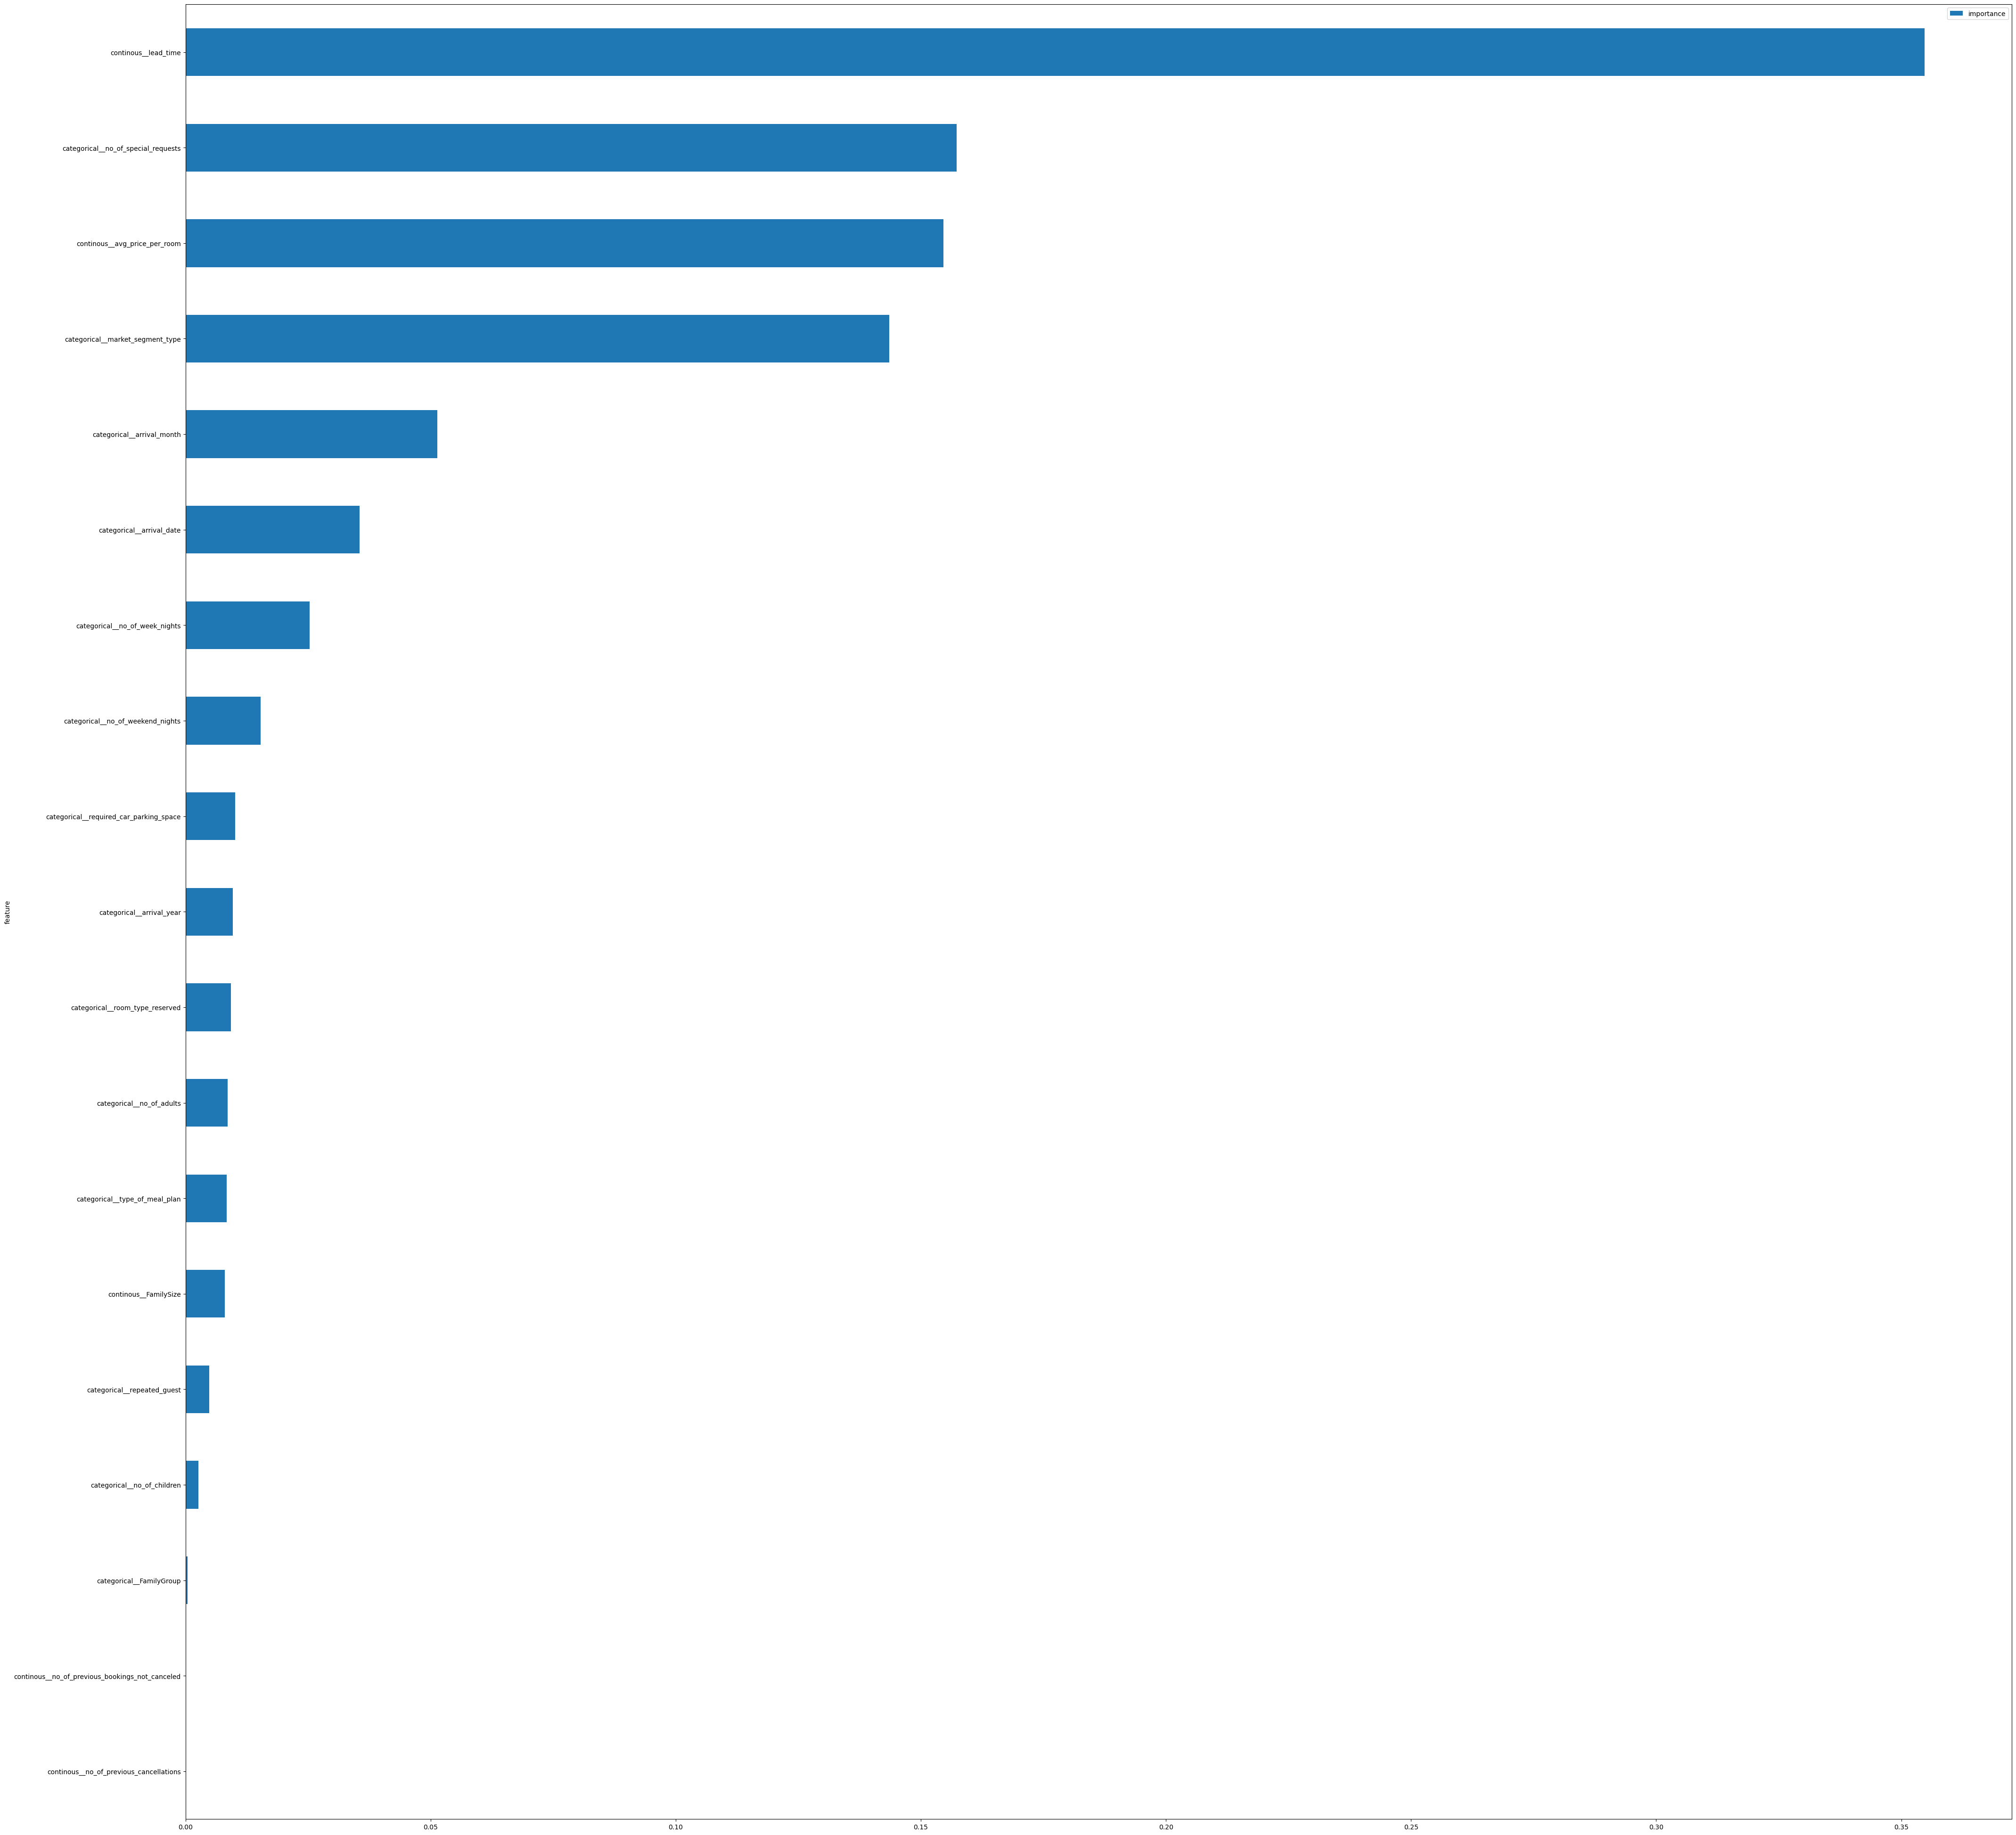

In [18]:
def plot_feature_importances(model, feature_names):
    features = pd.DataFrame({'feature': feature_names, 'importance':np.abs(clf.best_estimator_[3].feature_importances_)})
    features.sort_values(by=['importance'], ascending=True, inplace=True)
    features.set_index('feature', inplace=True)
    features.plot(kind='barh', figsize=(50, 50))
    return features
    
tmp = plot_feature_importances(clf.best_estimator_[3], feature_names)
tmp.tail(50)

In [19]:
test_data = pd.read_csv(os.path.join(dir, "test.csv"))
print(test_data.shape)
test_data.head()

(28068, 18)


,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
0,42100,3,0,1,4,0,0,1,111,2018,12,5,1,0,0,0,115.60,2
1,42101,2,0,0,3,0,0,0,22,2017,10,21,0,0,0,0,85.00,0
2,42102,2,2,0,1,0,0,3,18,2018,8,10,1,0,0,0,240.00,1
3,42103,2,0,0,3,0,0,0,88,2018,5,30,0,0,0,0,80.75,0
4,42104,1,0,0,2,2,0,0,7,2018,9,21,1,0,0,0,144.00,0


In [20]:
test_data['FamilySize'] = test_data['no_of_adults'] +  test_data['no_of_children'] + 1
test_data['FamilyGroup'] = test_data['FamilySize'].map(convert_familysize)

In [21]:
X_test = test_data
test_data['booking_status'] = clf.predict(X_test)
test_data.head()

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,...,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,FamilySize,FamilyGroup,booking_status
0,42100,3,0,1,4,0,0,1,111,2018,...,5,1,0,0,0,115.60,2,4,Small,0
1,42101,2,0,0,3,0,0,0,22,2017,...,21,0,0,0,0,85.00,0,3,Small,0
2,42102,2,2,0,1,0,0,3,18,2018,...,10,1,0,0,0,240.00,1,5,Medium,0
3,42103,2,0,0,3,0,0,0,88,2018,...,30,0,0,0,0,80.75,0,3,Small,0
4,42104,1,0,0,2,2,0,0,7,2018,...,21,1,0,0,0,144.00,0,2,Small,1


In [22]:
test_data.to_csv(os.path.join(dir, "submission1.csv"), columns=["id", "booking_status"], index=False)

In [50]:
#persist model using joblib
objects = {
    'clf':clf
}
joblib.dump(objects, os.path.join(dir, "model_gbst.pkl"))

['../data/model_gbst.pkl']